In [12]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation,PillowWriter,HTMLWriter
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

case_name='case10'

In [3]:
def regr_sided(X,Y,t,k,b):
    # Dispose points outside bandwidth
    YL=Y[np.logical_and(t-b<X,X<t)]
    XL=X[np.logical_and(t-b<X,X<t)]
    
    # Calculate weights
    get_weight=np.vectorize(lambda x:k((np.abs((x-t)))/b))
    WL=get_weight(XL)

    # Reshape for lib use
    # Every data has a single feature
    XL=XL.reshape(-1,1)
    YL=YL.reshape(-1,1)
    
    # Create linear regression object
    regrL = linear_model.LinearRegression()
    
    # Train the model using the training sets
    regrL.fit(XL, YL, sample_weight=WL)
    
    return regrL


def bias(X,Y,t,k,i):
    final_regr=regr_sided(X,Y,t,k,i)
    true_err=(final_regr.predict([[t]])[0][0]-actual_f(t))**2
    return true_err

In [4]:
def actual_f(x):
    return 0.2*((x-59)**2)+2

In [5]:
def get_data():
    n1=60
    n2=0.2
    m=18
    X=np.random.rand(n1)*10-5+59 #can change the distribution of X
    for i in range(1,m):
        A=59-np.random.rand(int(n2*(m-i)))*0.1*(m-i)
        X=np.hstack((X,A))
    for j in range(1,m):
        B=59-0.1*(m+j-1)-np.random.rand(int(n2*(m-j)))*0.1*(m-j)
        X=np.hstack((X,B))
    Y=np.vectorize(actual_f)(X)
    for k in range(3):
        Y=Y+0.6*np.random.rand(np.size(X))
    Y=Y-0.9
    Y=Y[np.logical_and(59-2.8**1.5<X,X<59)]
    X=X[np.logical_and(59-2.8**1.5<X,X<59)]
    return (X,Y)

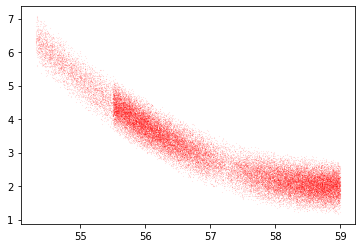

In [6]:
testset=[]
for i in range(500):
    v=get_data()
    testset.append(v)
    X,Y=v
    plt.scatter(X,Y,s=0.001,color='red')
plt.show()

In [7]:
def repeat_test(t,k,b):
    errsum=0
    cnt=0
    for (X,Y) in testset:
        errsum+=bias(X,Y,t,k,b)
        cnt+=1
    return errsum/cnt

In [8]:
def bezier(p,t):
    # See https://javascript.info/bezier-curve
    if len(p)==1:
        # This is a little bit different from the real bezier-curve
        # p[0] is (x,y) of the point
        # but x!=t, and we need to control x
        # so using (t,y) instead
        return p[0][1]
    p2=[]
    for i in range(len(p)-1):
        p2.append((1-t)*p[i]+t*p[i+1])
    return bezier(p2,t)

In [9]:
def gen_param():
    p=np.array([np.array([0,1]),
                np.random.rand(2),
                np.random.rand(2),
                np.array([1,0])])
    return [lambda x:bezier(p,x),p]

In [10]:
t=59
ker_cnt=200
band_steps=50
kb=np.zeros((ker_cnt,band_steps))
param_set=[]
for i in range(ker_cnt):
    g=gen_param()
    param_set.append(g)
    print('Running param set ',i,g[1][1:3])
    k=0
    for j in np.exp(np.linspace(-0.3,1.2,band_steps)):
        b=repeat_test(t,g[0],j)
        kb[i][k]=b
        k=k+1

Running param set  0 [[0.61181862 0.56248738]
 [0.92120999 0.1102569 ]]
Running param set  1 [[0.1452499  0.13212943]
 [0.59387046 0.16262907]]
Running param set  2 [[0.59068419 0.11550799]
 [0.86274538 0.54188591]]
Running param set  3 [[0.27425141 0.97370375]
 [0.82677206 0.91407164]]
Running param set  4 [[0.15594901 0.06198999]
 [0.87517383 0.30788775]]
Running param set  5 [[0.41368833 0.77545438]
 [0.22918988 0.51022096]]
Running param set  6 [[0.86110376 0.22929164]
 [0.72180017 0.32983655]]
Running param set  7 [[0.47774994 0.65465609]
 [0.76233974 0.84173728]]
Running param set  8 [[0.69599866 0.43769452]
 [0.39637879 0.72523838]]
Running param set  9 [[0.26279287 0.05772142]
 [0.9723301  0.32040876]]
Running param set  10 [[0.10198931 0.23646453]
 [0.94029825 0.39881346]]
Running param set  11 [[0.86861013 0.16956115]
 [0.06006651 0.71763807]]
Running param set  12 [[0.18402528 0.20856755]
 [0.44724458 0.15759504]]
Running param set  13 [[0.18330956 0.88952412]
 [0.94678484 0

In [11]:
f = open (r'outputbkt2.txt','w')
for param in param_set:
    print(i,param[1][1],param[1][2],file=f)
kerr=np.zeros(band_steps)+100
kbest=np.zeros(band_steps).astype(int)
for j in range(band_steps):
    for i in range(ker_cnt):
        if kerr[j]>kb[i][j]:
            kerr[j]=kb[i][j]
            kbest[j]=i
    print(kerr[j],kbest[j],file=f)

f.close()

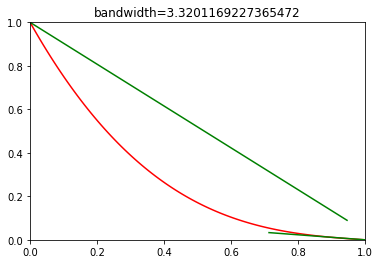

In [13]:
fig, ax = plt.subplots()
curve, = plt.plot([],[],color='red')
line1, = plt.plot([],[],color='green')
line2, = plt.plot([],[],color='green')

def init():
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    return
band_set=np.exp(np.linspace(-0.3,1.2,band_steps))
def animate(j):
    ax.set_title('bandwidth='+str(band_set[j]))
    ker=param_set[kbest[j]][0]
    p=param_set[kbest[j]][1]
    X=np.linspace(0,1,100)
    curve.set_data(X,np.vectorize(ker)(X))
    line1.set_data([p[0][0],p[1][0]],[p[0][1],p[1][1]])
    line2.set_data([p[2][0],p[3][0]],[p[2][1],p[3][1]])
    return curve,line1,line2

ani = FuncAnimation(fig=fig, func=animate, frames=band_steps, init_func=init, interval=30, blit=False)
writer = PillowWriter()
ani.save(case_name+"_graph.gif", writer=writer)
hwriter = HTMLWriter(fps=5)
ani.save(case_name+'_graph.html',writer=hwriter)